In [265]:
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, 
                             roc_auc_score, precision_score, recall_score,
                             confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from __future__ import annotations
import json
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

In [266]:
url = r".\data\S06-hw-dataset-01.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [267]:
correlations = df.corr(method='pearson')['target'].abs().sort_values(ascending=False)
correlations #матрица корреляций по Пирсону(ковариативность признаков деленная на произведение их вариативности)

target           1.000000
num19            0.480636
num18            0.242841
num07            0.227906
num06            0.220066
num17            0.217429
num20            0.212031
num22            0.210103
num14            0.198858
num02            0.142442
num16            0.087179
num21            0.066216
num13            0.043913
num08            0.030704
num01            0.016845
cat_contract     0.016673
num09            0.015627
num05            0.013207
num10            0.012029
num03            0.011327
cat_region       0.009318
num23            0.007073
id               0.005726
num11            0.004726
tenure_months    0.004512
cat_payment      0.004292
num04            0.004090
num15            0.002072
num12            0.002003
num24            0.000096
Name: target, dtype: float64

In [268]:
df.head()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [269]:
all_numeric = all(pd.api.types.is_numeric_dtype(df[col]) for col in df.columns)
print(f"Все признаки числовые? {all_numeric}")

Все признаки числовые? True


In [270]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,12000.0,6000.500000,3464.245950,1.000000,3000.750000,6000.500000,9000.250000,12000.000000
num01,12000.0,0.013705,2.096534,-8.155181,-1.423844,-0.047565,1.422676,8.610863
num02,12000.0,-0.005278,3.544498,-14.605579,-2.303772,0.053348,2.335937,16.299709
num03,12000.0,-0.002357,1.004417,-4.374043,-0.685618,-0.009186,0.671441,3.651692
num04,12000.0,0.038404,2.087318,-7.753301,-1.374579,0.038766,1.484417,7.571965
num05,12000.0,-0.006301,1.007329,-3.999332,-0.676552,-0.003728,0.669269,4.562115
num06,12000.0,-0.865297,3.888966,-15.238402,-3.532054,-1.092517,1.526389,16.223054
num07,12000.0,-0.702877,1.989513,-7.377252,-2.064888,-0.795907,0.522625,8.006444
num08,12000.0,-0.290694,3.455981,-13.853627,-2.597019,-0.208245,2.093169,13.030011
num09,12000.0,-0.008154,0.996677,-3.794637,-0.683959,-0.020883,0.666959,3.976868


In [271]:
df['target'].value_counts(normalize=True)

target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

In [272]:
df.isna().sum().sum() #проверка на пропуски датасета(пропусков данных не обнаружено)

np.int64(0)

In [273]:
for col, dtype in df.dtypes.items():
    print(f'{col} -> {dtype}')


id -> int64
num01 -> float64
num02 -> float64
num03 -> float64
num04 -> float64
num05 -> float64
num06 -> float64
num07 -> float64
num08 -> float64
num09 -> float64
num10 -> float64
num11 -> float64
num12 -> float64
num13 -> float64
num14 -> float64
num15 -> float64
num16 -> float64
num17 -> float64
num18 -> float64
num19 -> float64
num20 -> float64
num21 -> float64
num22 -> float64
num23 -> float64
num24 -> float64
cat_contract -> int64
cat_region -> int64
cat_payment -> int64
tenure_months -> int64
target -> int64


In [274]:
def compute_metrics(y_pred, y_test, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_test, y_pred))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, y_test, X_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:,1]
    metrics = compute_metrics(pred, y_test, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_test, y_pred, title: str):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.viridis, colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    return fig
 
def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return None
    
    fig, ax = plt.subplots(figsize=(8,6))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.set_title(title)
    plt.tight_layout()

    return fig
    


In [275]:
X = df[df.columns[1:len(df.columns)-1]]
feature_names = X.columns.to_list()
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)
#фиксируем random_state через константную переменную RANDOM_STATE чтобы разбиение было всегда одинаковым
#можно было задать значение в ячейнке через np.random.seed
#делаем стртификацию stratify, что зафиксировать распределение выходной переменной, сохраняя изначальный
#баланс при разбиении данных на обучающую и тестовую выборку

In [288]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
results = []
best_models = {}  
search_summaries = {}  

dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, y_test, X_test, "Dummy(stratified)"))
best_models["Dummy(stratified)"] = dummy

lr = Pipeline(
    steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE, 
                              l1_ratio=0, solver='lbfgs'))
    ])

lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    
}

lr_search = GridSearchCV(
    lr, lr_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    refit=True,
)

lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(Scaled)"] = {
    "best_params":lr_search.best_params_,
    "best_cv_roc_auc":float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, y_test, X_test, "LogReg(scaled)"))
results

[{'accuracy': 0.5754166666666667,
  'f1': 0.34045307443365697,
  'precision': 0.3420026007802341,
  'recall': 0.3389175257731959,
  'roc_auc': 0.5136705855466965,
  'model': 'Dummy(stratified)'},
 {'accuracy': 0.8275,
  'f1': 0.7076271186440678,
  'precision': 0.7828125,
  'recall': 0.645618556701031,
  'roc_auc': 0.7800137118480523,
  'model': 'LogReg(scaled)'}]

In [277]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator, 
        param_grid,
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True,
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params":  search.best_params_,
        "best_cv_roc_auc": float(search.best_score_)
    }
    results.append(evaluate_on_test(best, y_test, X_test, label))
    return search

In [294]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.9183278602765164}

In [279]:
rf = RandomForestClassifier(n_estimators=100, 
                            n_jobs=-1,
                            random_state=RANDOM_STATE,
                            oob_score=False,)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5]
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9691355545390421}

In [280]:
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE, early_stopping=True)
hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradient", hgb, hgb_grid)
search_summaries["HistGradient"]

{'best_params': {'learning_rate': 0.1,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.9733385894513183}

In [281]:
df = pd.DataFrame(results)

df_sorted = df.copy()
df_sorted["roc_auc"]
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])
df_sorted

,accuracy,f1,precision,recall,roc_auc,model
4,0.933750,0.893645,0.929068,0.860825,0.914710,HistGradient
3,0.925833,0.879240,0.928367,0.835052,0.902132,RandomForest
2,0.869167,0.794233,0.808000,0.780928,0.846129,DecisionTree
1,0.827500,0.707627,0.782813,0.645619,0.780014,LogReg(scaled)
0,0.575417,0.340453,0.342003,0.338918,0.513671,Dummy(stratified)


In [282]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json" #объединение строки и пути
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results" : df_sorted.to_dict(orient='records')}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [283]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('HistGradient',
 {'accuracy': 0.93375,
  'f1': 0.8936454849498328,
  'precision': 0.9290681502086231,
  'recall': 0.8608247422680413,
  'roc_auc': 0.9147104006906709,
  'model': 'HistGradient'})

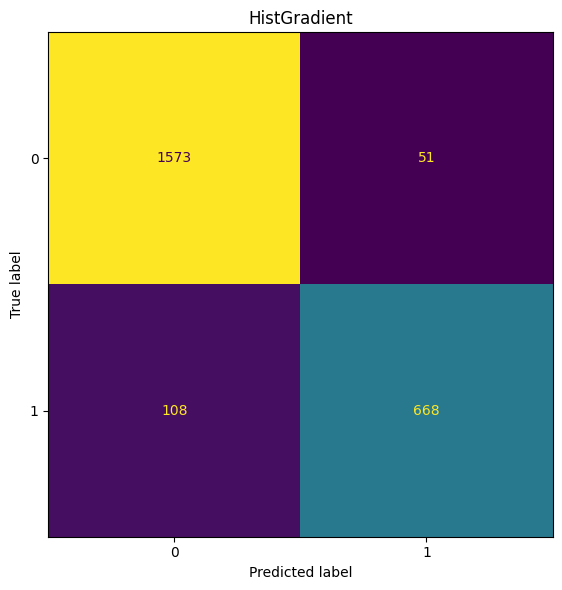

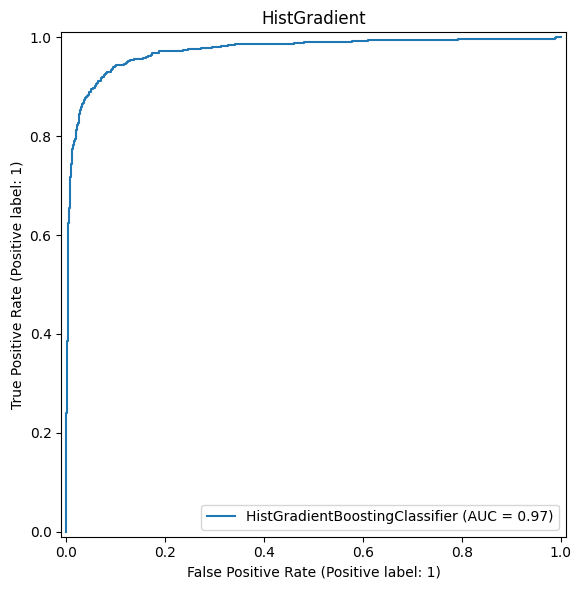

In [284]:

y_pred = best_model.predict(X_test)
conf_matr = plot_confusion(y_test, y_pred, best_label)
plt.savefig(r'.\artifacts\figures\conf_matrix.png')
plt.show()
plt.close(conf_matr)
roc_curve = plot_roc(best_model, X_test, y_test, best_label)
plt.savefig(r'.\artifacts\figures\roc_curve.png')
plt.show()
plt.close(roc_curve)
  

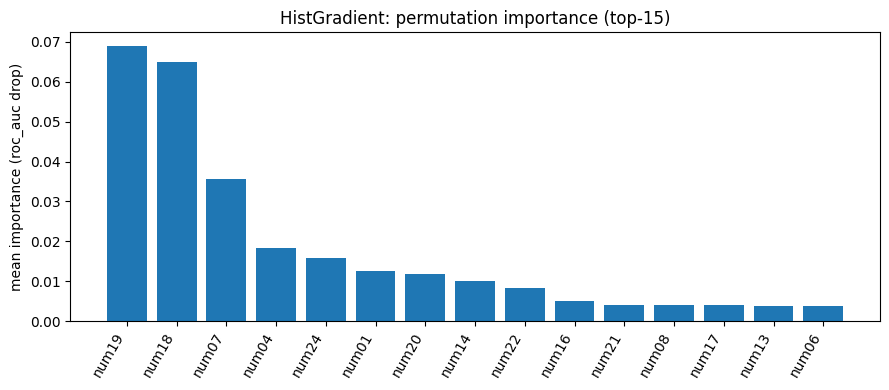

In [285]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model, 
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring,
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]
plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()
#признаки с названиями столбцов num19 и num18 оказывают наибольше вляиние на данные, что видно из графика
#наши ожидания совпали, так как при просмотре корреляции признаков через 
#корреляция Пирсона мы видели то же что и на графике, только в числовом виде

In [286]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")
     

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json
